In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm

# MNIST Data

In [2]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/MNIST/', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=128, shuffle=True, num_workers=4)
    
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/MNIST/', train=False, 
                   transform=transforms.ToTensor()),
    batch_size=128, shuffle=True, num_workers=4)

# VAE Model

In [3]:
from models import SmallVAE

In [4]:
device = torch.device("cuda")

In [5]:
model = SmallVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def show(img, title):
    npimg = img.numpy()
    plt.figure()
    plt.title(title)
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [7]:
def train(epoch):
    model.train()
    train_loss = 0
    for data, _ in tqdm(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = model.loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in tqdm(enumerate(test_loader)):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += model.loss(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(128, 1, 28, 28)[:n]])
                show(make_grid(comparison.cpu(), nrow=n), 'Reconstruction {}'.format(epoch))

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

# Train

In [8]:
epochs = 5

100%|██████████| 469/469 [00:02<00:00, 183.88it/s]

====> Epoch: 1 Average loss: 112.4636



79it [00:00, 241.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

====> Test set loss: 111.7179


100%|██████████| 469/469 [00:02<00:00, 177.81it/s]

====> Epoch: 2 Average loss: 111.8175



79it [00:00, 218.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

====> Test set loss: 111.0449


100%|██████████| 469/469 [00:02<00:00, 179.60it/s]

====> Epoch: 3 Average loss: 111.3859



79it [00:00, 247.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

====> Test set loss: 110.5110


100%|██████████| 469/469 [00:02<00:00, 180.27it/s]

====> Epoch: 4 Average loss: 111.0277



79it [00:00, 243.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

====> Test set loss: 110.2033


100%|██████████| 469/469 [00:02<00:00, 178.73it/s]

====> Epoch: 5 Average loss: 110.6871



79it [00:00, 240.10it/s]


====> Test set loss: 110.0395
CPU times: user 12.8 s, sys: 4.74 s, total: 17.6 s
Wall time: 15.2 s


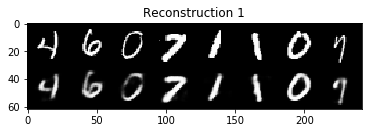

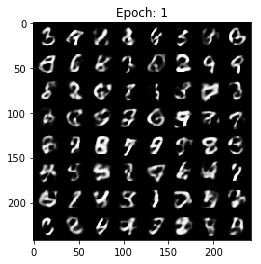

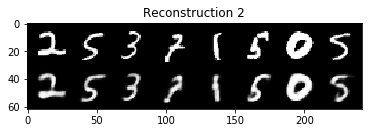

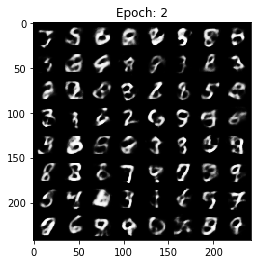

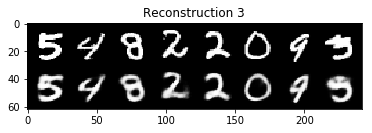

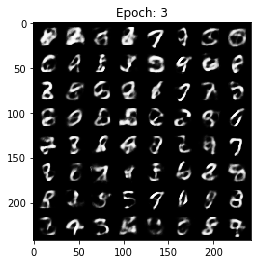

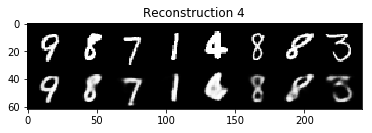

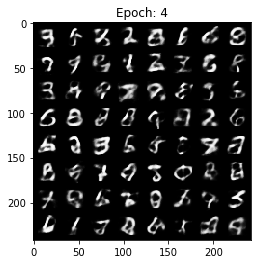

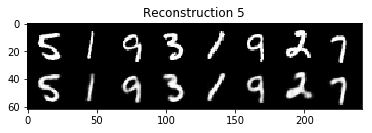

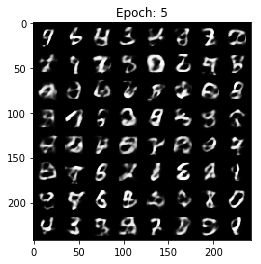

In [10]:
%%time
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = model.decode(sample).cpu()
        show(make_grid(sample.view(64, 1, 28, 28)), 'Sample {}'.format(epoch))